In [1041]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage import io # 미니맵 처리
from sklearn.preprocessing import MinMaxScaler

# pyautogui, pillow, opencv,

# https://developer.riotgames.com/docs/lol
api_key  = "RGAPI-979411cc-e130-4610-895f-3b771d336b13"
kr_api   = "https://kr.api.riotgames.com"
asia_api = "https://asia.api.riotgames.com"

In [2]:
# riot api
# RGAPI-7878fe8c-f7f2-4e2e-985f-8103910d5e13

# RATE LIMITS
# 20 requests every 1 seconds(s)
# 100 requests every 2 minutes(s)

# 플레이어 동선 정확도 높이기
# 각 라인별 zone을 좌표로 설정하기

- 3렙 탑갱이 승리에 끼치는 영향
- 처음 바위게의 중요성
- 첫 전령 vs 첫 용
- 정글 동선 바텀 위주 vs 탑 위주
- (미드, 정글), (탑, 정글) 좋은 조합
- 라인별 주도권 승률

스폰시간 <br>
대부분 정글 몬스터: 1분 30초, 리젠 2분 30초<br>
돌거북, 심술 두꺼비: 1분 42초, 리젠 2분 30초 <br>
협곡 바위 게: 3분 15초, 리젠 2분 30초,  처음엔 위아래 다뜨고 그 뒤엔 랜덤

# 티어별 유저 기본 데이터 가져오기

In [1050]:
def get_player_by_tier(api_key, queue="RANKED_SOLO_5x5", tier="challenger", division=1, page=1):
    high_tier = ["challenger", "grandmaster", "master"]
    
    # 마스터 이상
    if tier in high_tier:
        tier_api = f"{kr_api}/lol/league/v4/{tier}leagues/by-queue/{queue}?page={page}&api_key={api_key}"
        
    # 다이아 이하
    else:
        division = "I" * division
        tier_api = f"{kr_api}/lol/league/v4/entries/{queue}/{tier}/{division}?page={page}&api_key={api_key}"
        
    data      = requests.get(tier_api).json()
    league_df = pd.DataFrame(data)
    
    return league_df

In [1052]:
league_df = get_player_by_tier(api_key, tier="challenger")
league_df

In [1039]:
league_df["entries"][0]

{'summonerId': 'NJaE41IoAJyFgdWhBvONlyj_l0RV2HAZrzuzIvhhMPW34tI',
 'summonerName': '42141321',
 'leaguePoints': 648,
 'rank': 'I',
 'wins': 687,
 'losses': 641,
 'veteran': False,
 'inactive': False,
 'freshBlood': False,
 'hotStreak': False}

# 소환사 데이터 가져오기

In [508]:
summoner_id   = "JXue7UC14-I2rh7H8TYAUfSxwpo1kw4Ii8dJA4LlVpEajJo"
summoner_name = "코로나공유"

player1  = f"{kr_api}/lol/summoner/v4/summoners/{summoner_id}?api_key={api_key}"
response = requests.get(player1)
data     = response.json()
data

{'id': 'JXue7UC14-I2rh7H8TYAUfSxwpo1kw4Ii8dJA4LlVpEajJo',
 'accountId': '5eiUjQC-_2v5pVRd2-4acVLPM0qWl3wYPniCbbpVDcHO-BM',
 'puuid': 'jk_O1XQ-1qGCgRv2WoWyyGqI9rhELKVi62wOyOyStLJ1YJRmf1ckCW_J6HGyr0N2Ai7PV6X7hHLgsQ',
 'name': '코로나공유',
 'profileIconId': 29,
 'revisionDate': 1632582638000,
 'summonerLevel': 173}

In [509]:
summoner_puuid = data["puuid"]

In [510]:
match_list_api = f"{asia_api}/lol/match/v5/matches/by-puuid/{summoner_puuid}/ids?api_key={api_key}"
response       = requests.get(match_list_api)
match_list     = response.json()

# 기본 0부터 20개
match_list

['KR_5476691788',
 'KR_5476489810',
 'KR_5476449701',
 'KR_5476475155',
 'KR_5474254376',
 'KR_5474322054',
 'KR_5474340497',
 'KR_5474261454',
 'KR_5474194925',
 'KR_5474173379',
 'KR_5473749448',
 'KR_5473639354',
 'KR_5471556997',
 'KR_5469853340',
 'KR_5466288745',
 'KR_5466065552',
 'KR_5464868768',
 'KR_5464567334',
 'KR_5464479467',
 'KR_5464446203']

# match 데이터 가져오기
https://developer.riotgames.com/apis#match-v5/GET_getMatch

In [976]:
match_num = 5
match_data_api   = f"{asia_api}/lol/match/v5/matches/{match_list[match_num]}?api_key={api_key}"
response         = requests.get(match_data_api)
match_basic_data = response.json()

## 시간 변환

In [977]:
# 소환사의 협곡 map_id == 11

# gameDuration 분으로 변환
print(1425655 / 1000 / 60)

# gameCreation 변환
from datetime import datetime
ts = int("1632595525")
print(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))

23.760916666666667
2021-09-25 18:45:25


In [978]:
match_basic_data["info"]["gameCreation"]

1632525082000

In [979]:
print(match_basic_data.keys())
print(match_basic_data["info"].keys())
print(match_basic_data["info"]["platformId"])
print(match_basic_data["info"]["queueId"])
print(match_basic_data["info"]["tournamentCode"])
# print(match_data["info"]["teams"])

dict_keys(['metadata', 'info'])
dict_keys(['gameCreation', 'gameDuration', 'gameId', 'gameMode', 'gameName', 'gameStartTimestamp', 'gameType', 'gameVersion', 'mapId', 'participants', 'platformId', 'queueId', 'teams', 'tournamentCode'])
KR
420



## 스펠 api
- https://ddragon.leagueoflegends.com/cdn/11.19.1/data/ko_KR/summoner.json

In [980]:
# match_basic_data["info"]

# 타임라인 match 데이터 가져오기

In [981]:
timeline_match_api = f"{asia_api}/lol/match/v5/matches/{match_list[match_num]}/timeline?api_key={api_key}"

response   = requests.get(timeline_match_api)
time_match = response.json()

In [982]:
time_match.keys()

dict_keys(['metadata', 'info'])

In [983]:
time_match["metadata"]

{'dataVersion': '2',
 'matchId': 'KR_5474322054',
 'participants': ['nVfh03n4E_30wbCPQ0y8bRBSrLK9MSODGpBFE905Cg43PjSp--ZZiUHdAZdT2PeexKqJQeYc9rDQ_Q',
  'wpEvO4swHjW_7-x0rdvib5k34bibIM6ITmQVk30psWbTAxev-Y9qxv2fKXi8rFxsRfna9-O3SPcMEQ',
  'W-6d-dg-j0ywYyxLKn2K7gIH5goB85Qc2cIgtZGlq8jJSAgfgZKNLWhPZa_8yyTG68IBCAADQBoyvQ',
  'jk_O1XQ-1qGCgRv2WoWyyGqI9rhELKVi62wOyOyStLJ1YJRmf1ckCW_J6HGyr0N2Ai7PV6X7hHLgsQ',
  'Kxf9-BHfDzaH-bM_Wshs7fHxdTM-HkWbHzD75LK_nk78_1639vfU3lRdClyPU0EmYWj5lPJTpKSu7w',
  'tKRMjCr9ysSoBP6GDS9w5s_Yh2LQ9Lfi_qjjUCiF3MscwOV2IJGodsu5b-LllVzo37GM14gPkDtl_Q',
  'gp-z3cJgGlbvRAkB2k4VKWnC9nGZdORPOEMiW0CNOVCVbFN8bPzklwQTB5c3Pdo0gpyqhuXDBZwBqg',
  'Qo45I4j0rAN5W7qZpqVKVMWno0QGBtN6gDSgFB_qhZ_I_opvDlltpedzcS-ZHf9xWYXlFcbgl4PkMQ',
  'DKnIbNmbrqb4cRG70mzVtfpLmmGNL6twDkgN6COlx20h4DN91j2jVu_MkpjlrkmviYdncoJxbGb5BQ',
  '4ET9bcx0WWaS3zlcv2CMNYD01G1_5R96H9bunH9y8CXAhApRhPsAUBSfM6a8B8J5aJxdy4hh3ZklGg']}

In [984]:
time_match["info"]["participants"]

[{'participantId': 1,
  'puuid': 'nVfh03n4E_30wbCPQ0y8bRBSrLK9MSODGpBFE905Cg43PjSp--ZZiUHdAZdT2PeexKqJQeYc9rDQ_Q'},
 {'participantId': 2,
  'puuid': 'wpEvO4swHjW_7-x0rdvib5k34bibIM6ITmQVk30psWbTAxev-Y9qxv2fKXi8rFxsRfna9-O3SPcMEQ'},
 {'participantId': 3,
  'puuid': 'W-6d-dg-j0ywYyxLKn2K7gIH5goB85Qc2cIgtZGlq8jJSAgfgZKNLWhPZa_8yyTG68IBCAADQBoyvQ'},
 {'participantId': 4,
  'puuid': 'jk_O1XQ-1qGCgRv2WoWyyGqI9rhELKVi62wOyOyStLJ1YJRmf1ckCW_J6HGyr0N2Ai7PV6X7hHLgsQ'},
 {'participantId': 5,
  'puuid': 'Kxf9-BHfDzaH-bM_Wshs7fHxdTM-HkWbHzD75LK_nk78_1639vfU3lRdClyPU0EmYWj5lPJTpKSu7w'},
 {'participantId': 6,
  'puuid': 'tKRMjCr9ysSoBP6GDS9w5s_Yh2LQ9Lfi_qjjUCiF3MscwOV2IJGodsu5b-LllVzo37GM14gPkDtl_Q'},
 {'participantId': 7,
  'puuid': 'gp-z3cJgGlbvRAkB2k4VKWnC9nGZdORPOEMiW0CNOVCVbFN8bPzklwQTB5c3Pdo0gpyqhuXDBZwBqg'},
 {'participantId': 8,
  'puuid': 'Qo45I4j0rAN5W7qZpqVKVMWno0QGBtN6gDSgFB_qhZ_I_opvDlltpedzcS-ZHf9xWYXlFcbgl4PkMQ'},
 {'participantId': 9,
  'puuid': 'DKnIbNmbrqb4cRG70mzVtfpLmmGNL6twDkgN6C

In [985]:
time_match["info"].keys()

dict_keys(['frameInterval', 'frames', 'gameId', 'participants'])

In [986]:
match_data = time_match["info"]["frames"]

In [987]:
"""
events: 게임 내에서 발생한 사건 데이터
participantFrames: 각 플레이어 인게임 정보
timestamp: 기록된 시간(1분마다 기록이 된다.)

match_data는 1분 단위로 기록됩니다.
"""
print(len(match_data))
match_data[0].keys()

15


dict_keys(['events', 'participantFrames', 'timestamp'])

In [1002]:
# match_data[0]["participantFrames"]["1"]["championStats"]
# match_basic_data["info"]["participants"][1]

## 한 경기에서 나오는 모든 이벤트 종류

In [989]:
event_types = []
for match in match_data:
    for event in match["events"]:
        event_types.append(event["type"])
list(set(event_types))

['PAUSE_END',
 'CHAMPION_KILL',
 'ITEM_SOLD',
 'ELITE_MONSTER_KILL',
 'ITEM_DESTROYED',
 'LEVEL_UP',
 'SKILL_LEVEL_UP',
 'WARD_KILL',
 'WARD_PLACED',
 'CHAMPION_SPECIAL_KILL',
 'GAME_END',
 'ITEM_UNDO',
 'TURRET_PLATE_DESTROYED',
 'BUILDING_KILL',
 'ITEM_PURCHASED']

# 플레이어 포지션 구분

라인 구분하는 기준에 관련한 docs 입니다. <br>
https://riot-api-libraries.readthedocs.io/en/latest/roleid.html
- Role과 Lane 데이터를 사용하여 Postion을 정하면 87.5%의 정확도를 가집니다.

> The easiest (and most inaccurate) way to correct roles is to just use the Role and Lane data and convert to Position based on the below mapping. This yields about 87.5% accuracy. <br>
    (MID_LANE, SOLO): MIDDLE, <br>
    (TOP_LANE, SOLO): TOP, <br>
    (JUNGLE, NONE): JUNGLE, <br>
    (BOT_LANE, DUO_CARRY): BOTTOM, <br>
    (BOT_LANE, DUO_SUPPORT): UTILITY <br>

In [990]:
match_data[10].keys()

dict_keys(['events', 'participantFrames', 'timestamp'])

In [992]:
print(match_basic_data.keys())
print(match_basic_data["info"].keys())

dict_keys(['metadata', 'info'])
dict_keys(['gameCreation', 'gameDuration', 'gameId', 'gameMode', 'gameName', 'gameStartTimestamp', 'gameType', 'gameVersion', 'mapId', 'participants', 'platformId', 'queueId', 'teams', 'tournamentCode'])


In [993]:
# match_basic_data["info"]["participants"][n]

In [994]:
n = 1
match_basic_data["info"]["participants"][n]["summonerId"]
match_basic_data["info"]["participants"][n]["championId"]
print(match_basic_data["info"]["participants"][n]["puuid"])
print(match_basic_data["info"]["participants"][n]["championName"])
# print(match_basic_data["info"]["participants"][n]["participantId"])
# print(match_basic_data["info"]["participants"][n]["teamId"])

print(match_basic_data["info"]["participants"][n]["role"])
print(match_basic_data["info"]["participants"][n]["lane"])
print(match_basic_data["info"]["participants"][n]["individualPosition"])
print(match_basic_data["info"]["participants"][n]["teamPosition"])

wpEvO4swHjW_7-x0rdvib5k34bibIM6ITmQVk30psWbTAxev-Y9qxv2fKXi8rFxsRfna9-O3SPcMEQ
Taliyah
SUPPORT
NONE
JUNGLE
JUNGLE


In [995]:
match_basic_data["info"].keys()

dict_keys(['gameCreation', 'gameDuration', 'gameId', 'gameMode', 'gameName', 'gameStartTimestamp', 'gameType', 'gameVersion', 'mapId', 'participants', 'platformId', 'queueId', 'teams', 'tournamentCode'])

In [996]:
# match_basic_data["info"]["participants"][1]

In [997]:
print(time_match["info"].keys())
time_match["info"]["participants"]

# 스마와 정글몹 킬 수로 정글러 파악 가능
# match_data[-1]["participantFrames"]["4"]["jungleMinionsKilled"]

# 미니언 킬 수, 레벨이 가장 낮은 플레이어가 서폿

dict_keys(['frameInterval', 'frames', 'gameId', 'participants'])


[{'participantId': 1,
  'puuid': 'nVfh03n4E_30wbCPQ0y8bRBSrLK9MSODGpBFE905Cg43PjSp--ZZiUHdAZdT2PeexKqJQeYc9rDQ_Q'},
 {'participantId': 2,
  'puuid': 'wpEvO4swHjW_7-x0rdvib5k34bibIM6ITmQVk30psWbTAxev-Y9qxv2fKXi8rFxsRfna9-O3SPcMEQ'},
 {'participantId': 3,
  'puuid': 'W-6d-dg-j0ywYyxLKn2K7gIH5goB85Qc2cIgtZGlq8jJSAgfgZKNLWhPZa_8yyTG68IBCAADQBoyvQ'},
 {'participantId': 4,
  'puuid': 'jk_O1XQ-1qGCgRv2WoWyyGqI9rhELKVi62wOyOyStLJ1YJRmf1ckCW_J6HGyr0N2Ai7PV6X7hHLgsQ'},
 {'participantId': 5,
  'puuid': 'Kxf9-BHfDzaH-bM_Wshs7fHxdTM-HkWbHzD75LK_nk78_1639vfU3lRdClyPU0EmYWj5lPJTpKSu7w'},
 {'participantId': 6,
  'puuid': 'tKRMjCr9ysSoBP6GDS9w5s_Yh2LQ9Lfi_qjjUCiF3MscwOV2IJGodsu5b-LllVzo37GM14gPkDtl_Q'},
 {'participantId': 7,
  'puuid': 'gp-z3cJgGlbvRAkB2k4VKWnC9nGZdORPOEMiW0CNOVCVbFN8bPzklwQTB5c3Pdo0gpyqhuXDBZwBqg'},
 {'participantId': 8,
  'puuid': 'Qo45I4j0rAN5W7qZpqVKVMWno0QGBtN6gDSgFB_qhZ_I_opvDlltpedzcS-ZHf9xWYXlFcbgl4PkMQ'},
 {'participantId': 9,
  'puuid': 'DKnIbNmbrqb4cRG70mzVtfpLmmGNL6twDkgN6C

# 플레이어 동선 시각화 (726*600)

In [1007]:
axes   = []
minute = 3 # 3분에서 바텀 상황 리플레이 돌려보자.

for order_num in match_data[minute]["participantFrames"]:
    cur_position = match_data[minute]["participantFrames"][order_num]["position"]
    x, y = cur_position["x"], cur_position["y"]
    axes.append([x, y])

In [1008]:
x_range = np.array([0, 15000]).reshape((-1, 1))
y_range = np.array([0, 15000]).reshape((-1, 1)) 

# x 따로, y 따로
x_axes = [[ax[0]] for ax in axes]
y_axes = [[ax[1]] for ax in axes]

# 0부터 50, 680 부터 726, 총 96
player_x_scaler = MinMaxScaler(feature_range=(40, 680)).fit(x_range)
# player_x_scaler = MinMaxScaler(feature_range=(0, 726)).fit(x_range)

# 0부터 20, 580부터 600, 총 40
player_y_scaler = MinMaxScaler(feature_range=(10, 580)).fit(y_range)
# player_y_scaler = MinMaxScaler(feature_range=(0, 600)).fit(y_range)

player_x_position = player_x_scaler.transform(x_axes)
player_y_position = player_y_scaler.transform(y_axes)

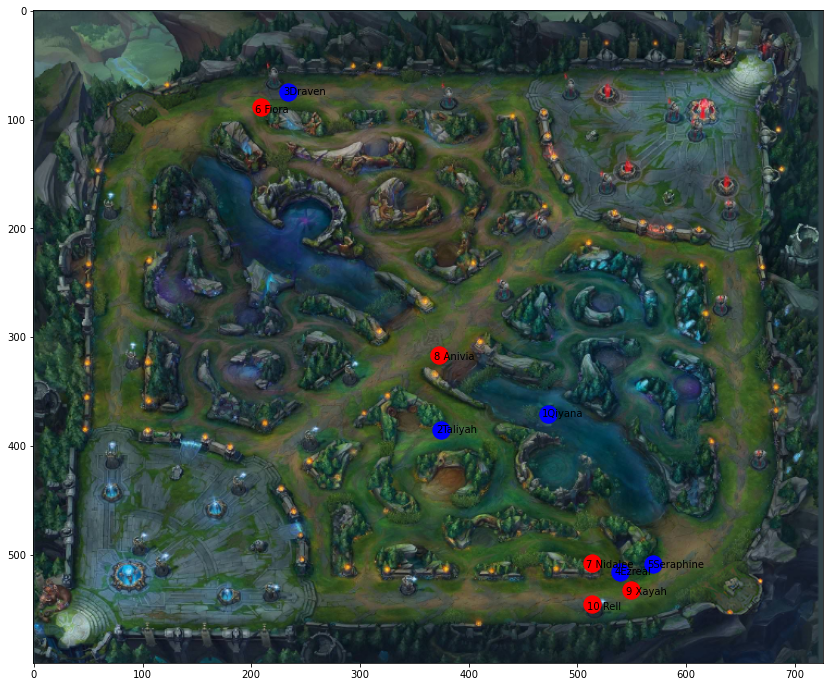

In [1009]:
# 726 * 600 사이즈
map_url = "https://preview.redd.it/anfqyl1ef2041.png?width=726&format=png&auto=webp&s=a93e43da6d4e0f702cd54fafa5dacc3111bce8fb"
image   = io.imread(map_url)
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

i = 1
for position_x, position_y in zip(player_x_position, player_y_position):
    champion = match_basic_data["info"]["participants"][i - 1]["championName"]
    # blue 팀
    if i < 6:
        # 각각의 값은 이미지에 맞게 좌표를 추가적 스케일링을 진행한 것입니다.
        ax.scatter(position_x + 15, 600 - position_y - 15, c="blue", s=300)
        ax.annotate(text=f"{i}{champion}",  xy=(position_x + 10, 600 - position_y - 12))
    
    # red 팀
    else:
        # 각각의 값은 이미지에 맞게 좌표를 추가적 스케일링을 진행한 것입니다.
        ax.scatter(position_x - 30, 600 - position_y + 30, c="red", s=300)
        ax.annotate(text=f"{i} {champion}",  xy=(position_x - 35, 600 - position_y + 35))
    i += 1

ax.axis('on')
ax.imshow(image)
plt.show()

In [1010]:
# match_data[minute]["events"]
match_data[minute + 1]["events"]

[{'killerId': 7,
  'timestamp': 182723,
  'type': 'WARD_KILL',
  'wardType': 'YELLOW_TRINKET'},
 {'itemId': 2003,
  'participantId': 4,
  'timestamp': 182756,
  'type': 'ITEM_DESTROYED'},
 {'level': 3, 'participantId': 6, 'timestamp': 182888, 'type': 'LEVEL_UP'},
 {'levelUpType': 'NORMAL',
  'participantId': 6,
  'skillSlot': 3,
  'timestamp': 184640,
  'type': 'SKILL_LEVEL_UP'},
 {'creatorId': 7,
  'timestamp': 187780,
  'type': 'WARD_PLACED',
  'wardType': 'UNDEFINED'},
 {'bounty': 300,
  'killStreakLength': 0,
  'killerId': 1,
  'position': {'x': 11877, 'y': 3395},
  'timestamp': 190884,
  'type': 'CHAMPION_KILL',
  'victimDamageDealt': [{'basic': False,
    'magicDamage': 84,
    'name': 'Nidalee',
    'participantId': 5,
    'physicalDamage': 0,
    'spellName': 'javelintoss',
    'spellSlot': 0,
    'trueDamage': 0,
    'type': 'OTHER'}],
  'victimDamageReceived': [{'basic': False,
    'magicDamage': 0,
    'name': 'Qiyana',
    'participantId': 1,
    'physicalDamage': 51,
    '

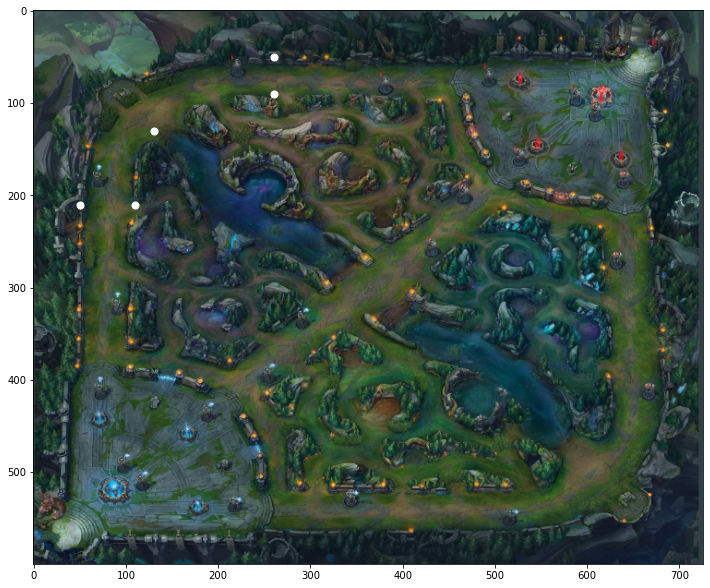

<Figure size 432x288 with 0 Axes>

In [1011]:
# 0부터 50, 680부터 726, 총 96
# 0부터 20, 580부터 600, 총 40

img_url = "https://preview.redd.it/anfqyl1ef2041.png?width=726&format=png&auto=webp&s=a93e43da6d4e0f702cd54fafa5dacc3111bce8fb"
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.scatter(
    [50, 110, 260, 260, 130],
    [210, 210, 50, 90, 130],
    c='white',
    s=50
)
ax.axis('on')
ax.imshow(io.imread(img_url))
plt.show()

ax.set_xlim(0, 1200)
ax.set_ylim(1200, 0)
plt.tight_layout()
plt.show()

# x=210, y=210


In [ ]:
# 공식 사이트에 존재하는 map image
# http://ddragon.leagueoflegends.com/cdn/6.8.1/img/map/map11.png

In [1020]:
# match_basic_data["info"]["participants"][0]
# assists, championId, championName, damageDealtToBuildings, damageDealtToObjectives, damageSelfMitigated
# gameEndedInEarlySurrender, gameEndedInSurrender, goldEarned, individualPosition,
# totalDamageDealtToChampions, physicalDamageTaken, totalMinionsKilled

# 챔피언 조합 분석
- 점수 기준
kda, 챔피언 딜량, 받은 데미지, 구조물 딜량, 오브젝트 딜량, 승패 유무, 흭득골드량, 미니언 처치 수

## 탑, 정글
- 각 라인의 챔프 점수 구하기
- 두 라인의 조합에서의 점수 구하기

## 미드, 정글